# Homework 5 - Visit the Wikipedia hyperlinks graph!

***Work done by Nagham Almagout, Cristina Falconi and Ilaria Servadio.***

**[RQ1]** Build the graph $[ G = (V, E)] $, where $V$ is the set of articles and $E$ the hyperlinks among them, and provide its basic information:

    - If it is direct or not
    - The number of nodes
    - The number of edges
    - The average node degree. Is the graph dense?
    
Show which packages we used:

In [1]:
# Load and work with the data:
import pandas as pd
import numpy as np
import csv
import pickle
import time

from collections import OrderedDict

# A way of using operating system dependent functionality:
import os
os.chdir('C:/Users/Admin/Desktop/ADM/Homework5')

# Functions creating iterators:
import itertools as it

# Creation, manipulation, and study of the networks:
import networkx as nx

# Visualization:
import matplotlib.pyplot as plt
%matplotlib inline

#Display image:
from IPython.display import Image

The first thing to do is to load the txt file we downloaded from [Wikicat hyperlink graph.](https://drive.google.com/file/d/1ghPJ4g6XMCUDFQ2JPqAVveLyytG8gBfL/view) In this file, every row is an **edge** and the two elements are the **nodes** *(source and destination)*. We load our document and transform it into a dataframe which is easy to handle.

In [2]:
# We read it as a list because this list will serve us later to check if the nodes belong
# to the categories we consider or not: 
data = list(csv.reader(open('wiki-topcats-reduced.txt', 'r'), delimiter='\t'))
df = pd.DataFrame(data) # Turn it into a dataframe
df.columns = ['Source', 'Destination'] # Rename the columns
df.head() # Show the first five rows

,Source,Destination
0,52,401135
1,52,1069112
2,52,1163551
3,62,12162
4,62,167659


Now we check if by mistake within our dataframe there are two or more equal lines that are repeated, *for example*:

|Source | Destination |
| --- | --- | 
| 52 | 100 | 
| 52 | 100 |

If this happens we are going to eliminate all the repeated edges more than once, otherwise we proceed our analysis.

In [3]:
df_clean = df.drop_duplicates() # we eliminate duplicates if there are any

The length of the two data frames is the same so there are no duplicates within our data frame, then we proceed with the analysis with the initial dataframe:

In [4]:
len(df.index) == len(df_clean) 

True

**The text of the homework requires to take into account all the categories that have a number of articles above 3500** 

So, what we do now is:

Define a function that reads the file with all the categories and scroll through all the lines of the file, if the length of the line is greater than or equal to 3500 then we consider the category corresponding to that line and all its articles (nodes) saving it in the dictionary, otherwise do not take it into account.

In [5]:
def data_aggregator(file):
    cat_data=dict() # {'Category: English_footballers': ['article1','article2',....,'article-n'],..}
    with open(file,'r') as r:
        for line in r:
            l=list(line.split(' '))
            if len(l)>3501:
                key=l[0].split(':')[1].replace(';','')
                cat_data[key]=l[1:]
    return cat_data


cat_data=data_aggregator('wiki-topcats-categories.txt')      

Thirty-five are the categories that have a number of articles above 3500, however it is said that all are present within our graph.

In [6]:
len(cat_data)

35

It's time to go and see which articles / nodes belong to the categories previously saved in our dictionary:

1) *`list(cat_data.values())`*: we get a list of the values in a dictionary. However this is not a simple list but a nested list because the values corresponding to each dictionary key are lists. Example: *[['22860','28411','28961'],['22863','23456']]*.

2) *`list(it.chain(nodes))`* : convert a nested list into one-dimensional list;

3) *`set(nodes)`*: we eliminate all the duplicates so we consider all the nodes only once.

In [7]:
nodes=list(cat_data.values()) # nested list
nodes=list(it.chain(*nodes)) # insert all the values into a single list
nodes=set(nodes) # consider the unique values

The next step is read *data* where each row represents an edge and the two elements are the nodes. In the case of both nodes of the row belong to the *nodes* list (that is to the nodes of the categories that have passed the initial check), then we save that edge. Subsequently, we transform the new_data list that contains all the edges in a dataframe and save this last in a csv file as if we were to serve it later we do not have to re-launch the code.

In [8]:
new_data=[] 
for i in range(len(data)):
    if data[i][0]  in nodes and data[i][1]  in nodes:
        new_data.append(data[i])  
df1 =pd.DataFrame(new_data) #transform into dataframe
df1.columns = ['Source', 'Destination'] #rename the columns
df1.to_csv('sdnodes.csv') #save as csv file
df1.head() #show the first five rows

,Source,Destination
0,52,401135
1,52,1069112
2,52,1163551
3,62,12162
4,62,167659


As we can see here, the number of edges has now decreased compared to those we originally had.

In [9]:
print('{} is the initial number of edges'.format(len(data)),
      'while {} is the number of current edges.'.format(len(new_data)))

2645247 is the initial number of edges while 2645160 is the number of current edges.


Parallel analysis:

What do we mean by the sentence above? We want to say that by constructing the graph directly from the text 'wiki-topcats-reduced.txt' we have a certain number of edges while building the graph after the check on the categories we have another number of edges. Based on what we need, we can analyze one of the two graphs.

It is time to create our **graph** as a dictionary in which the keys are the starting nodes and the values are the destination nodes.

In [10]:
graph = dict() #{52:[1234,6789]}
for row in df1.itertuples(): # read all the lines of our data frame
    source = row.Source # take the starting node
    if source in graph: 
        graph[source].append(row.Destination) # add a new destination to the source nodes
    else:
        graph[source] = [row.Destination] #create a new key with the first destination

***The first question we must answer is whether the graph is direct or not:*** 

We recall, [a directed graph](https://mathinsight.org/definition/directed_graph) is graph in which the nodes are connected together and where ***all the edges are directed from one vertex to another***. In contrast, a graph where the edges are bidirectional is called an undirected graph.

To answer this question we have created a function `g_is_dircted(graph)` that returns **True** if the graph is directed otherwise it returns **False**. Let's go explain in detail:

All we need to do is find a node $x$ that has an edge that connects it with the node $y$ but the node $y$ in turn is not connected to $x$ with any edge, then the **graph is direct**.

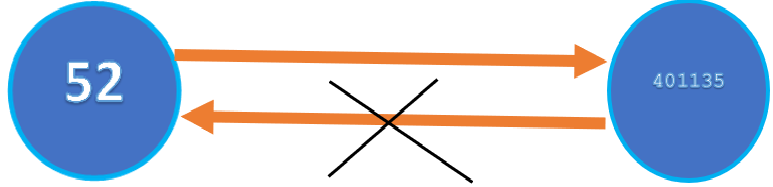

In [2]:
Image(filename = 'ila2.png')

In [11]:
   def g_is_dircted(graph):
    for key in graph: #scroll the keys
        for value in graph[key]: #for each key scroll its values
            if value in graph and key not in graph[value]: #if key is not neighbor for value -> direct
                #if for vertex y there is no vertex x in its adjacent vertices list
                print(key,'has as a neighbor',value)
                print('but',key, 'is not neighbor for',value)
                print('In fact, in the destinations of ',value,'we do not find ',key,':',graph[value])
                return True
    return False

g_is_dircted(graph)     

52 has as a neighbor 401135
but 52 is not neighbor for 401135
In fact, in the destinations of  401135 we do not find  52 : ['60219', '167532', '400980', '401018', '401019', '401053', '401067', '401137', '401154', '401171', '401184', '401227', '401231', '401295', '401310', '401315', '401457', '401474', '401505', '401609', '401628', '401975', '401981', '402265', '402300', '402715', '402718', '447882', '595633', '606279', '630946', '723911', '724192', '776478', '809904', '810461', '824998', '827334', '946986', '961942', '1058269', '1060341', '1061728', '1061824', '1061885', '1061905', '1062323', '1062938', '1161659', '1163338', '1163407', '1163551', '1163806', '1169888', '1184217', '1184538', '1245651', '1288076', '1288276', '1394526', '1399606', '1571179']


True

To answer the subsequent questions we decided to do a parallel analysis:
- by hand writing the codes to respond to requests
- using the 'networkx' package for a further check on the correctness of the results.

In [12]:
# Graph from 'new_data':
G=nx.DiGraph() # Create an empty direct graph with no nodes and no edges
G.add_edges_from(new_data) #we add edges from our list
print(nx.info(G)) #return the information regarding the graph

Name: 
Type: DiGraph
Number of nodes: 461178
Number of edges: 2645160
Average in degree:   5.7357
Average out degree:   5.7357


In [13]:
# Graph from data: 
G1=nx.DiGraph() # Create an empty direct graph with no nodes and no edges
G1.add_edges_from(data) #we add edges from our list
print(nx.info(G1)) #return the information regarding the graph

Name: 
Type: DiGraph
Number of nodes: 461193
Number of edges: 2645247
Average in degree:   5.7357
Average out degree:   5.7357


##### Handmade:
1) `Number of nodes`: to get this number we have taken two lists, one containing all the starting nodes and the other containing all the arrival nodes. Obviously, within these lists there can be repetitions since from a node can start more than one edge then we take the unique values (eliminating the duplicates) thanks to the *set*. Since a node can be both,souce and destination, we get the *union* between the two sets. The union returns the nodes that belong to both the set taken only once and the nodes that belong to a set but not to the other. At this point, if we count the number of elements in *all_nodes* we have obtained the number of nodes of our graph.

2) `Number of edges`: since inside our dataframe each row represents an edge, to obtain the number of edges it is sufficient to count the number of rows of the dataframe.

3) `The average node degree`: in the case of directed graph the average degree (recall that *the degree k of a vertex is the number of edges connecting it*) is $\langle k \rangle = \frac{E}{N}$ where $E$ is the number of edges and $N$ is the number of nodes.

In [14]:
# Graph from new_data: 
source = df1['Source'].tolist()
destination = df1['Destination'].tolist()
#len(destination) == len(source) -> return True

source = set(source)
destination = set(destination)
all_nodes = source.union(destination)
nodes = len(all_nodes)

# Graph from data: 
s = df['Source'].tolist()
d = df['Destination'].tolist()

print('{} is the initial number of nodes from the txt file'.format(len(set(s).union(set(d)))),
      'while {} is the number of current nodes (after the check on the categories).'.format(nodes))

461193 is the initial number of nodes from the txt file while 461178 is the number of current nodes (after the check on the categories).


In [15]:
edges = len(df1.index)
edges

2645160

In [16]:
def average_degree(N,E):
    return E/N

round(average_degree(nodes,edges),4)

5.7357

We can graph the distribution of degree:

As we can see from the first graph, the concentration is in the first 80/100 so we prefer to do an analysis focused on it and we'll make it in the second graph. 

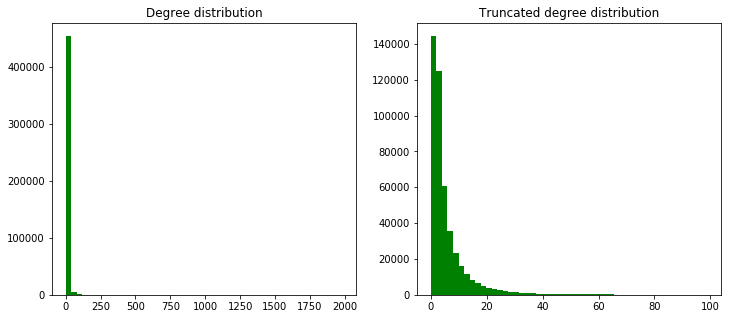

In [17]:
adjacency_m = nx.adjacency_matrix(G) #Adjacency Matrix

fig = plt.subplots(figsize=(12,11))

plt.subplot(2, 2, 1)
degrees = np.array(adjacency_m.sum(axis=1)).squeeze()
plt.title('Degree distribution')
plt.hist(degrees, bins = 50, facecolor='green')

plt.subplot(2, 2, 2)
degrees_truncated = degrees[degrees < 100]
plt.title('Truncated degree distribution')
plt.hist(degrees_truncated, facecolor='green', bins = 50)

plt.show()

The last question we have yet to answer is: ***Is the graph dense?***

A *dense graph* is a graph in which the number of edges is close to the maximum number of edges (if we have $N$ nodes there are $N - 1$ directed edges than can lead from it; therefore, the maximum number of edges is $N\times(N - 1)$). While a graph with few edges is a *sparse graph*.

The density for directed graphs is: $$d = \frac{E}{N(N-1)}$$
where $N$ and $E$ are respectively, the number of nodes and the number of edges in the graph

In [18]:
#handmade:
def density(E,N):
    E = float(E)
    N = float(N)
    return E/(N*(N-1))

density(edges,nodes)

1.2437002604441754e-05

In [19]:
# with networkx:
nx.density(G)

1.2437002604441754e-05

The density is 0 for a graph without edges and 1 for a complete graph; also, the density of multigraphs or graphs with self loops can be higher than 1. In our case, the density is almost zero therefore, the the graph is not dense.

**---------------------------------------------------------------------------------------------------------------**

**[RQ2]** Given a category $C_0 = \{article_1, article_2, \dots \}$ as input we want to rank all of the nodes in V according to the following criteria:

+ Obtain a block-ranking, where the blocks are represented by the categories. In particular, we want:

$$block_{RANKING} =\begin{bmatrix} C_0 \\ C_1 \\ \dots \\ C_c\\ \end{bmatrix}$$

Each category corresponds to a list of nodes.
The first category of the rank, $C_0$ , always corresponds to the input category. The order of the remaining categories is given by:

$$distance(C_0, C_i) = median(ShortestPath(C_0, C_i))$$

The lower is the distance from $C_0$, the higher is the $C_i$ position in the rank. 
$ShortestPath(C_0, C_i)$ is the set of all the possible shortest paths between the nodes of $C_0$ and $C_i$ . Moreover, the length of a path is given by the sum of the weights of the edges it is composed by.

+ Once you obtain the $[block_{RANKING}]$ vector, you want to sort the nodes in each category. The way you should sort them is explained by this example:
+ Suppose the categories order, given from the previous point, is $[C_0, C_1, C_2]$

** --------------------------------------------------------------------------------------------------------------------------------------------------**

### In this question, we have chosen Dijkstra algorithm to find the shortest paths between the categories:
**Algorithm:**
+  Create a dictionary of distance between source and all other nodes in the graph, with initial values Infinity "np.Inf" for all nodes except the initial node 'source', set distance 0.
+  For the current node, consider all of its neighbors and calculate their tentative distances through the current node. Compare the newly calculated tentative distance to the current assigned value and assign the smaller one. 
+  When we are done considering all of the neighbors of the current node, we select the node that is marked with the smallest tentative distance, set it as the new "current node", and go back to step 2.
+  Repeat until finding the shortest paths between source and all other nodes in the graph.

First, we find all shortest paths between each node of the input category, we chose **'American Jews'** as an input category, and all other nodes in the graph, then store them in a pickle file related to each node. So each node hae a  pickle file contain the shortest paths between it and all other nodes in the graph.
Then, for each category, we find the median of all shortest paths between nodes of input category and its nodes.

#### Checking the number of nodes in each category, and then choose one of the smallest categories as an input category:

In [26]:
for key in cat_data.keys():
    print(key+':'+str(len(cat_data[key])))

English_footballers:9237
The_Football_League_players:3357
Association_football_forwards:4819
Association_football_goalkeepers:3047
Association_football_midfielders:6028
Association_football_defenders:4587
Living_people:335400
Year_of_birth_unknown:3479
Harvard_University_alumni:2516
Major_League_Baseball_pitchers:2833
Members_of_the_United_Kingdom_Parliament_for_English_constituencies:6541
Indian_films:5739
Year_of_death_missing:6830
English_cricketers:2141
Year_of_birth_missing_(living_people):33513
Rivers_of_Romania:7729
Main_Belt_asteroids:13703
Asteroids_named_for_people:442
English-language_albums:4853
English_television_actors:3319
British_films:4551
English-language_films:19074
American_films:4659
Fellows_of_the_Royal_Society:3388
People_from_New_York_City:3663
American_Jews:3542
American_television_actors:11231
American_film_actors:4802
Debut_albums:7462
Black-and-white_films:4917
Year_of_birth_missing:3846
Place_of_birth_missing_(living_people):3422
Article_Feedback_Pilot:3468

In [20]:
cat_input = input('Enter a category: ')

Enter a category: American_Jews


#### We chose "American Jews"that contain '3542' nodes as an input category

Obviously, you can choose one of the 35 categories as input category, the algorithm will work anyway, producing different results.

### Dijksra Algorithm

In [3]:
from pythonds.graphs import PriorityQueue, Graph, Vertex

"""This is the function of Dijkstra algorithm"""
def dijkstra(graph,start):
    pq = PriorityQueue()
    dist=dict()# a dictionary contain all the smallest paths from the start node to all other nodes in the graph. 
    for v in graph:
        dist[v]=np.Inf # set Infinity to all nodes' distance except the source node
    dist[start]=0 # set 0 to the distance of the source node
    pq.buildHeap([(dist[v],v) for v in graph])# heap that will store in the nodes and distance
    while not pq.isEmpty():
        current_node = pq.delMin() # select the node with the smallest distance
        for next_node in graph.neighbors(current_node): # for each node in current node neighbors
            new_dist = dist[current_node]+1 # calculate the new distance
            if new_dist < dist[next_node]: # if the new distance smaller than old one 
                dist[next_node]=new_dist # node distance=new one
                pq.decreaseKey(next_node,new_dist) #moves to next node
    # removing nodes that its distance = Infinity, that meaning there is no path between source and this node
    new_dist=dict()
    for key in dist.keys():
        if dist[key]!=np.Inf:
            new_dist[key]=dist[key]
    return new_dist

"""This function is to calculate the shortest paths between nodes that belong to input category and 
all other nodes in the graph"""
def all_shortest_paths(graph,cat_data):
    all_shortest_paths=[]
    category_input_nodes=list(cat_data['American_Jews'])#our input category is American Jews
    #category_input_nodes=list(cat_data['cat_input'])
    category_input_nodes[len(category_input_nodes)-1]=category_input_nodes[len(category_input_nodes)-1].replace('\n','')
    for node1 in category_input_nodes:
        dist=dict()
        if node1 in graph:
            dist[node1]=dijkstra(graph, node1)# calculate the shortest paths of each node and store tham in a pickle file
            with open('filename'+node1+'.pickle', 'wb') as handle:
                 pickle.dump(dist, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### To check if our algorithm working correctly, we compare between it and networkx algorithm.

**Graph example:**

In [4]:
G=nx.DiGraph() 
G.add_edges_from([['52', '401135'],
 ['52', '1069112'],
 ['52', '1163551'],
 ['62', '12162'],
 ['62', '167659'],
 ['62', '279122'],
 ['62', '1089199'],
 ['62', '1354553'],
 ['62', '1400636'],
 ['62', '1403619'],
 ['52', '62'],
 ['52', '12162']])

**Implementation of our algorithm:**

In [23]:
'''our algorithm'''
start_time = time.time()
ours_d=dijkstra(G,'52')
print("--- %s seconds ---" % (time.time() - start_time))
ours_d

--- 0.0 seconds ---


{'1069112': 1,
 '1089199': 2,
 '1163551': 1,
 '12162': 1,
 '1354553': 2,
 '1400636': 2,
 '1403619': 2,
 '167659': 2,
 '279122': 2,
 '401135': 1,
 '52': 0,
 '62': 1}

**Implementation of networkx algorithm:**

In [25]:
'''networkx algorithm'''
start_time = time.time()
net_d=nx.shortest_path_length(G, '52',None)
print("--- %s seconds ---" % (time.time() - start_time))
net_d

--- 0.0 seconds ---


{'1069112': 1,
 '1089199': 2,
 '1163551': 1,
 '12162': 1,
 '1354553': 2,
 '1400636': 2,
 '1403619': 2,
 '167659': 2,
 '279122': 2,
 '401135': 1,
 '52': 0,
 '62': 1}

                      We got same results, and it is fast, so our algorithm working well.

Get meadian of all shortest paths between the input category and all other categories
$$distance(C_0, C_i) = median(ShortestPath(C_0, C_i))$$

First, we will get all shortest paths between each node of C0 to all other nodes in the graph

In [ ]:
#calling the function to find the shortest paths and store them in pickle files
all_shortest_paths(G,cat_data)

In [27]:
"""This function is to get the median of all shortest paths between C0 and Ci"""
def get_shortest_paths_between_two_category(cat_data,category_target):
    all_shortest_path=[]# a list of all shortest paths between C0 and each Ci
    median=0
    inf=0
    dist=dict()
    category_input_nodes=list(cat_data['American_Jews'])# our C0 is American Jews category
    category_input_nodes[len(category_input_nodes)-1]=category_input_nodes[len(category_input_nodes)-1].replace('\n','')
    category_target_nodes=list(cat_data[category_target])#Ci
    category_target_nodes[len(category_target_nodes)-1]=category_target_nodes[len(category_target_nodes)-1].replace('\n','')
    for node1 in category_input_nodes: # for each node in C0
        if node1 in G:#check if the node is in the graph just to be sure
            try:
                with open('filename'+node1+'.pickle', 'rb') as handle:
                    dist = pickle.load(handle)# distance between node of C0 and all other nodes in the graph
                    for node2 in category_target_nodes:#for each node in Ci
                        if node2 in G and node2 in dist[node1].keys():# if there is a path between the two nodes
                            all_shortest_path.append(dist[node1][node2])#append the distance between the two nodes in all shortest paths list
                        elif node2 in G and node2 not in dist[node1].keys():# if there is no path between nodes 
                            inf+=1#increase the infinity values count    
            except:
                continue
    return sorted(all_shortest_path),inf# return the sorted shortest paths and the infinity values number between C0 and Ci

"""This function is calling previous function to get the sorted shortest paths list and the number of infinty values
number between C0 and Ci"""                
def get_all_shortest_paths(G,cat_data):
    median=dict()
    for category in cat_data.keys():# for each category Ci get the sorted shortest paths and the number of infinty values
        if category!='American_Jews':#American Jews is our input category
            shortest,inf=get_shortest_paths_between_two_category(G,cat_data,category)#get the sorted shortest paths and the infinity values count
            with open(''+category+'short.pickle', 'wb') as handle1:
                pickle.dump(shortest, handle1, protocol=pickle.HIGHEST_PROTOCOL)#store the shortest paths of each category
                handle1.close()
            with open(''+category+'inff.pickle', 'wb') as handle2:#store the infinity values number of each category
                pickle.dump(inf, handle2, protocol=pickle.HIGHEST_PROTOCOL)
                handle2.close()
            shortest=None
            del shortest    
            

### calling the function to get the shortest paths and infinity values number between C0 and all Ci
get_all_shortest_paths(cat_data)

Now, while we got the sorted shortest paths and the inifity values number between C0 and each Ci, then we will check if the inifity values number is larger than the number of shortest paths, so the median will be Infinity, otherwise we will get the number that is fall in the middle of the [shortest paths+infinity values] list, considering the length of the list is the number of the shortest paths plus the infinity values number, if the length is odd, or we will sum the two numbers that fall in the middle of the list and divide it on 2 to get the median.
The formula of the median is:
+ if the count of the  numbers is odd, then:
$$median(a)=a[length(a)/2]$$
+ if the count of the  numbers is even, then:
$$median(a)=(a[length(a)/2]+a[length(a)/2+1])/2$$

**Again the length of the list is number of shortest paths between $C_0$ and $C_i$ + infinity values number between $C_0$ and $C_i$**

In [18]:
median=dict()
for category in cat_data.keys():
    with open(''+category+'short.pickle', 'rb') as handle1:
        shortest=pickle.load(handle1)
    with open(''+category+'inff.pickle', 'rb') as handle2:
        inf=pickle.load(handle2)
    if len(shortest)<inf:#if the infinity values number is larger than length of shortest paths
        median[category]=np.Inf#then the median is Infinity
    elif (len(shortest)+inf)%2==0:#check if the length of the whole list is even
        median[category]=(shortest[int((len(shortest)+inf)/2)]+shortest[int((len(shortest)+inf)/2)+1])/2#second formula
    else:#the length of the whole list is odd
        median[category]=float(shortest[int((len(shortest)+inf)/2)])#first formula

In [34]:
with open('median.pickle', 'wb') as handle:
                 pickle.dump(median, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
with open('median.pickle', 'rb') as handle:
    median = pickle.load(handle)

### Obtaining a block-ranking
$$block_{RANKING} =\begin{bmatrix} C_0 \\ C_1 \\ \dots \\ C_c\\ \end{bmatrix}$$
Now, we got the median and we need just to sort them to obtain the blocking ranking and save it in a pickle file

In [36]:
import operator
block_ranking = sorted(median.items(), key=operator.itemgetter(1))

In [37]:
with open('block_ranking.pickle', 'wb') as handle:
                 pickle.dump(block_ranking, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
with open('block_ranking.pickle', 'rb') as handle:
    block_ranking = pickle.load(handle)

In [30]:
block_ranking

[('American_Jews', 0),
 ('British_films', 5.0),
 ('English-language_films', 5.0),
 ('American_films', 5.0),
 ('American_television_actors', 5.0),
 ('American_film_actors', 5.0),
 ('Black-and-white_films', 5.0),
 ('English_footballers', 6.0),
 ('Members_of_the_United_Kingdom_Parliament_for_English_constituencies', 6.0),
 ('Indian_films', 6.0),
 ('Year_of_birth_missing_(living_people)', 6.0),
 ('Rivers_of_Romania', 6.0),
 ('English-language_albums', 6.0),
 ('English_television_actors', 6.0),
 ('People_from_New_York_City', 6.0),
 ('Place_of_birth_missing_(living_people)', 6.0),
 ('American_military_personnel_of_World_War_II', 6.0),
 ('Fellows_of_the_Royal_Society', 7.0),
 ('Article_Feedback_Pilot', 7.0),
 ('The_Football_League_players', 8.0),
 ('Windows_games', 8.0),
 ('Association_football_forwards', inf),
 ('Association_football_goalkeepers', inf),
 ('Association_football_midfielders', inf),
 ('Association_football_defenders', inf),
 ('Living_people', inf),
 ('Year_of_birth_unknown', in

**We notice that there are many categories are equal in distance, so to rank these categories we will add 1 - the rate of nodes that connect $C_0$ to $C_i$, to the block ranking dictionary and re order it, so the one with higher rate of nodes that connect $C_0$ to $C_i$ will have higher rank**

In [75]:
"""Re-order block ranking"""
new_block_ranking=dict()
for category in median.keys():
    new_block_ranking[category]=[]
    with open(''+category+'short.pickle', 'rb') as handle1:
        s=pickle.load(handle1)
    with open(''+category+'inff.pickle', 'rb') as handle2:
        f=pickle.load(handle2)
    new_block_ranking[category]=[median[category],np.round(1-len(s)/(len(s)+f),2)]

In [96]:
new_block_ranking

{'American_Jews': [0, 0.0],
 'American_film_actors': [5.0, 0.13],
 'American_films': [5.0, 0.03],
 'American_military_personnel_of_World_War_II': [6.0, 0.46],
 'American_television_actors': [5.0, 0.13],
 'Article_Feedback_Pilot': [7.0, 0.39],
 'Association_football_defenders': [inf, 0.81],
 'Association_football_forwards': [inf, 0.9],
 'Association_football_goalkeepers': [inf, 1.0],
 'Association_football_midfielders': [inf, 0.88],
 'Asteroids_named_for_people': [inf, 0.71],
 'Black-and-white_films': [5.0, 0.27],
 'British_films': [5.0, 0.03],
 'Debut_albums': [inf, 0.78],
 'English-language_albums': [6.0, 0.32],
 'English-language_films': [5.0, 0.03],
 'English_cricketers': [inf, 0.76],
 'English_footballers': [6.0, 0.34],
 'English_television_actors': [6.0, 0.31],
 'Fellows_of_the_Royal_Society': [7.0, 0.39],
 'Harvard_University_alumni': [inf, 0.52],
 'Indian_films': [6.0, 0.14],
 'Living_people': [inf, 0.76],
 'Main_Belt_asteroids': [inf, 0.88],
 'Major_League_Baseball_pitchers': [

In [97]:
import operator
new_block_ranking2 = sorted(new_block_ranking.items(), key=operator.itemgetter(1))

In [98]:
"""here as example: 0.03 that meaning the rate of nodes that connect the two categoriws is 0.97 """
new_block_ranking2

[('American_Jews', [0, 0.0]),
 ('British_films', [5.0, 0.03]),
 ('English-language_films', [5.0, 0.03]),
 ('American_films', [5.0, 0.03]),
 ('American_television_actors', [5.0, 0.13]),
 ('American_film_actors', [5.0, 0.13]),
 ('Black-and-white_films', [5.0, 0.27]),
 ('Rivers_of_Romania', [6.0, 0.03]),
 ('Indian_films', [6.0, 0.14]),
 ('Members_of_the_United_Kingdom_Parliament_for_English_constituencies',
  [6.0, 0.23]),
 ('People_from_New_York_City', [6.0, 0.23]),
 ('Year_of_birth_missing_(living_people)', [6.0, 0.27]),
 ('English_television_actors', [6.0, 0.31]),
 ('English-language_albums', [6.0, 0.32]),
 ('English_footballers', [6.0, 0.34]),
 ('Place_of_birth_missing_(living_people)', [6.0, 0.39]),
 ('American_military_personnel_of_World_War_II', [6.0, 0.46]),
 ('Fellows_of_the_Royal_Society', [7.0, 0.39]),
 ('Article_Feedback_Pilot', [7.0, 0.39]),
 ('The_Football_League_players', [8.0, 0.42]),
 ('Windows_games', [8.0, 0.46]),
 ('Harvard_University_alumni', [inf, 0.52]),
 ('Year_of_

### Sorting the nodes in each category
Once you obtain the block_ranking vector, you want to sort the nodes in each category. The way you should sort them is explained by this example:
+ Each category corresponds to a list of nodes.
+ Suppose the categories order, given from the previous point, is $C_0, C_1, C_2$

In [104]:
for key in cat_data.keys():
    cat_data[key]=sorted(cat_data[key])

#### You will notice that one article might belong to a single category or multiple ones. In the case it belongs to more than one:
+ If the article belongs to the input category (we will talk about this in RQ2) it belongs to that one.
+ Otherwise, the category of the article will correspond, among the categories it belongs to, to the closest to the input category.

#### To solve this issue:
We create a dictionary that contain all nodes as keys and the categories that each node belong to as values, started from nodes in input category, and so on for each category in blocking ranking.

In [105]:
articles=dict()
for item in new_block_ranking2:
    for article in cat_data[item[0]]:
        if article in articles:
            articles[article].append(item[0])
        else:
            articles[article]=[item[0]]

### Obtaining our new categories data and storing them in a pickle file

For each node in articles dictionary if this node belong to more than one category, we keep it in the first category that it belong to and remove it from others, becase when we did the articles dictionary we started from input category and went ahead in blocking ranking, so we assign it the categories that it belong to in the same order of the distance of each category from input one

In [106]:
for article in articles:
    if len(articles[article])>1:
        for category in articles[article][1:]:
            cat_data[category].remove(article)

In [107]:
with open('cat_data.pickle', 'wb') as handle:
    pickle.dump(cat_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [108]:
with open('cat_data.pickle', 'rb') as handle:
    cat_data = pickle.load(handle)

In [110]:
cat_list=[]
for item in new_block_ranking2:
    cat_list.append(item[0])

In [112]:
new_cat_data={}
for category in cat_list:
    new_cat_data[category]=cat_data[category]
with open('new_cat_data.pickle', 'wb') as handle:
    pickle.dump(new_cat_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

**------------------------------------------------------------------------------------------------------------------------**

**[Step 1]**Compute subgraph induced by $C_0$ . For each node compute the sum of the weigths of the in-edges.
$$score_{article_i} = \sum_{j \in in-edges(article_i)} w_j$$

**[STEP 2]**Extend the graph to the nodes that belong to $C_1$ . Thus, for each article in $C_1$ compute the score as before. Note that the in-edges coming from the previous category, $C_0$ , have as weights the score of the node that sends the edge.

**[STEP 3]**Repeat Step2 up to the last category of the ranking. In the last step of the example you clearly see the weight update of the edge coming from node E.

As we can read from the documentation, *“pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream  is converted back into an object hierarchy*.

Open the file we have previously made: within this file there is a dictionary with keys the 35 categories and as values the list of their articles / nodes.

In [66]:
# Load the dictionary back from the pickle file
with open('new_cat_data.pickle', 'rb') as handle:
    cat_data = pickle.load(handle) #Read a pickled object representation from the open file

As we can see again, the number of categories we are considering is 35, i.e. all those categories that have passed the initial check (contain more than 3500 articles).

In [67]:
len(cat_data)

35

- `nx.to_dict_of_lists(G)`: return adjacency representation of graph as a dictionary of lists. We show, for example, the first value of d_edges:
$$ d_{edges} = {\{52:[401135, 1069112, 1163551],...}\}$$

In [68]:
d_edges = nx.to_dict_of_lists(G)

** Now let's see in detail how we did steps 1,2,3 :**

- `d = {}`: first we initialize an empty dictionary, which will then have as key the name of the category and as a value a dictionary that has all the nodes of that category and the weights associated with them. For example:  $d = \{English footballers: \{52: 3,1234:0\},...\}$

    ***STEP 1***:
    - `for i,cat in enumerate(cat_data)`: We scroll through our dictionary **cat_data** which has the categories as keys and as nodes the values associated to them. If the index `i` is 0 then it is of the $C_0$ category that we speak and then computes subgraph induced by $C_0$.
    - `G.subgraph(cat_data[cat])`: the induced subgraph (*relating to the category that we consider from time to time*) of the graph contains the nodes in nodes and the edges between those nodes.
    - `subgraph_C0.in_degree`: as we can read from the networkx documentation,the node in_degree is the number of edges pointing to the node. The weighted node degree is the sum of the edge weights for edges incident to that node.
    - `d[cat][el[0]] = el[1]`: for each node in the category we associate its weight (*el[1]*).
    
    ***STEP 2/3***:
    
    The procedure we adopt now, is similar to what was done before (ie we calculate the subgraph related to the category and in_degree) but for each node of this category we are considering we must see if there are some in-edges that start from the nodes of the previous subgraph.
    - For every node X in this category, we `try` to scroll all the nodes Y,Z,etc.. connected to X (`for n in d_edges[el[0]]`). If the nodes we are checking (Y,Z,..) are part of the previous subgraph then it means that at the node X of this subgraph there are also edges from the previous subgraph. In this case, the weight is not only the same as what we get from in_degree but we must add the weight obtained from the previous subgraph: `d[cat][el[0]] += d[i-1][n] + el[1]`.
    - In the case in which we find no edges from nodes of the previous category (`except`), we associate as weight el[1] (as also done in step 1).

In [69]:
d = {}
for i,cat in enumerate(cat_data):
    # STEP 1 
    if i == 0:
        d[cat] = {}
        subgraph_C0 = G.subgraph(cat_data[cat]) 
        #The induced subgraph of the graph contains the nodes in nodes 
        #and the edges between those nodes.
        #list(subgraph.edges) return example > [('A', 'B'), ('A', 'C'), ('B', 'C')]
        #list(subgraph.nodes) > ['C', 'A', 'B']
        for el in subgraph_C0.in_degree: #example return > InDegreeView({'C': 2, 'A': 0, 'B': 1})
            d[cat][el[0]] = el[1] #el = ('C', 2) #el[0] = 'C' #el[1] = 2
    # STEP 2-3
    else:
        d[cat] = {}
        subgraph_C_i = G.subgraph(cat_data[cat]) 
       
        for el in subgraph_C_i.in_degree:#example return > InDegreeView({'C': 2, 'A': 0, 'B': 1})
            try:
                for n in d_edges[el[0]]:
                    if n in d[i-1].keys():
                        d[cat][el[0]] += d[i-1][n] + el[1] #i-1 > previous category
            except:
                d[cat][el[0]] = el[1]

In [71]:
#save our dictionary within a file
with open('subgraph.pickle', 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

We saved the result in a file, which you can find in our repository if you are interested in seeing the weight associated with each node in each category.

In [72]:
len(d) #Another check: the dictionary read all 35 categories.

35

**Ranking:**

The next step is to sort the nodes within the categories from the largest to the smallest and then put them all together in one list.

In [73]:
d_descending = list()
for cat in d:
    d_descending.append(list(OrderedDict(sorted(d[cat].items(),
                                                key=lambda kv: kv[1], reverse=True)).keys()))
    
rank=list(it.chain(*d_descending)) 
#because d_descending is a nested list, in this way we transform it into a one-dimensional list.

Now let's see the name of each node in our rank list:

In [75]:
# Load the data:
name = list(csv.reader(open('wiki-topcats-page-names.txt', 'r'),delimiter = ' '))
# 'name' is a list in which each element is made up of the index associated with the node and its name

#Now let's separate the indexes from the names and 
#then create a dataframe that has its own IDs and names as columns.
article_and_name = list()
for el in name:
    id = el[0]
    name_article = ' '.join(str(e) for e in el[1:])
    article_and_name.append([el[0],name_article])
df =pd.DataFrame(article_and_name) #transform into dataframe
df.columns = ['ID', 'Name']
df.head(2)

,ID,Name
0,0,Chiasmal syndrome
1,1,Kleroterion


In [76]:
#We insert our rank list within a data frame
df1 = pd.DataFrame({'Article': rank})
df1.head(2)

,Article
0,1061960
1,1400463


We only show a small part of the final result, but if you are interested in seeing the complete output, we have saved it in a file that you can find in our repository.

In [77]:
ranking = df1.merge(df,left_on='Article', right_on='ID') #Merge the two dataframe
ranking1 = ranking[['Article','Name']]
ranking1.to_csv('ranking.csv') #save as csv file
ranking1.head(10) #Show the first 10 elements.

,Article,Name
0,1061960,Steven Spielberg
1,1400463,American Jews
2,1092009,Albert Einstein
3,1163693,Marilyn Monroe
4,1163623,George Burns
5,1163814,Groucho Marx
6,1169029,Henry Kissinger
7,1163776,Jack Benny
8,1061192,Lee Strasberg
9,1061697,Mike Nichols


Here we show for each category the two nodes with the greatest weight:

In [78]:
d_descending1 = {}
for cat in d:
    d_descending1[cat] = (dict(OrderedDict(sorted(d[cat].items(),
                                                key=lambda kv: kv[1], reverse=True)).items()))

for key, value in d_descending1.items():
    c = 0
    for e in value.items():
        if c < 2:
            print(key, e)
            c += 1
        else:
            break

American_Jews ('1061960', 48)
American_Jews ('1400463', 36)
British_films ('1041937', 1500)
British_films ('1253712', 15)
English-language_films ('1063315', 66)
English-language_films ('1061272', 60)
American_films ('572855', 198)
American_films ('1062319', 9)
American_television_actors ('1061971', 154)
American_television_actors ('1163665', 103)
American_film_actors ('1061501', 139)
American_film_actors ('1265360', 85)
Black-and-white_films ('1065212', 7)
Black-and-white_films ('1268561', 7)
Rivers_of_Romania ('786913', 278)
Rivers_of_Romania ('786295', 151)
Indian_films ('582718', 31)
Indian_films ('589341', 18)
Members_of_the_United_Kingdom_Parliament_for_English_constituencies ('540950', 247)
Members_of_the_United_Kingdom_Parliament_for_English_constituencies ('539587', 233)
People_from_New_York_City ('1400222', 37)
People_from_New_York_City ('1400399', 22)
Year_of_birth_missing_(living_people) ('1156802', 17)
Year_of_birth_missing_(living_people) ('1261640', 15)
English_television

**What if we wanted to graphically represent these subgraphs?**
The following code shows how we would do it, however the cell to save the graph within a png file is not runnated due to the high execution time.

We show the code for the $C_O$ category, obviously the code remains unchanged for the other categories, we only need to change the name of the category we are considering.

In [80]:
#Show the packages needed
import igraph
import cairocffi as cairo

In [81]:
#Load the data:
#in this file there are the arcs between all the nodes of the 35 categories and 
#not only between the nodes of the C_0 category
df_graph = pd.read_csv('sdnodes.csv', usecols=['Source','Destination']) 
nodes_C_o = set(cat_data['American_Jews']) #Let's take the nodes of the C_0 category

In [82]:
subgraph = {}
# Create our subgraph -> subgraph = {'A': ['B','C'], 'B': ['A']}
for row in df_graph.itertuples():
    source = str(row.Source)
    destination = str(row.Destination)
    if source in nodes_C_o and destination in nodes_C_o:
        if source not in subgraph:
            subgraph[source] = [destination]
        else:
            subgraph[source].append(destination)
#Let's add the isolated nodes:
#that is those nodes that are reached by some arcs but from which no arch does not start
for node in nodes_C_o:
    if node not in subgraph.keys():
        subgraph[node] = []

In [83]:
#Create an empty graph
g = igraph.Graph(directed = True)

g.add_vertices(list(map(str,subgraph.keys()))) #add vertices

edges = [(str(v),str(a)) for v in subgraph.keys() for a in subgraph[v]]
g.add_edges(edges) #add edges

#Above each node we want to show its weight
g.vs['label'] = [d['American_Jews'][k] for k in d['American_Jews']]

# Create the plot
plt = igraph.plot(g,vertex_size = 15,bbox = (400,400))

In [ ]:
plt.save('subgraph_C_0.png')